In [1]:
import keras.layers
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, balanced_accuracy_score

2024-12-11 20:49:31.219612: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 20:49:31.221329: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 20:49:31.262242: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 20:49:31.263967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 20:49:32.049144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Loading the matlab file
data = loadmat("shuttle.mat")
X, y = data["X"], data["y"]

In [3]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
features_dim = X_train.shape[1]
contamination_rate = np.mean(y_train)
print("Contamination rate: ", contamination_rate)

Contamination rate:  0.07169626853511488


In [4]:
# Min-Max normalization 
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
class Autoencoder(keras.Model):
    def __init__(self):
        super().__init__()

        self.encoder = keras.Sequential()
        self.encoder.add(keras.layers.Dense(8, "relu", input_dim=9))
        self.encoder.add(keras.layers.Dense(5, "relu", input_dim=8))
        self.encoder.add(keras.layers.Dense(3, "relu", input_dim=5))

        self.decoder = keras.Sequential()
        self.decoder.add(keras.layers.Dense(5, "relu", input_dim=3))
        self.decoder.add(keras.layers.Dense(8, "relu", input_dim=5))
        self.decoder.add(keras.layers.Dense(9, "sigmoid", input_dim=8))
    
    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

In [6]:
autoencoder = Autoencoder()
sample = np.expand_dims(X_train[3], axis=0)
print(sample)
print(autoencoder(sample))

[[0.17171717 0.47675018 0.46875    0.50701506 0.36858974 0.4576556
  0.5620915  0.63081862 0.5755627 ]]
tf.Tensor(
[[0.5076639  0.5363468  0.50860244 0.49176306 0.49373177 0.5029033
  0.49087462 0.48637137 0.4921286 ]], shape=(1, 9), dtype=float32)


In [7]:
opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(loss=keras.losses.MeanSquaredError(), optimizer=opt)
history = autoencoder.fit(x=X_train, y=X_train, epochs=50, batch_size=1024, validation_data=(X_test, X_test))

Epoch 1/50
24/24 [==============================] - 1s 9ms/step - loss: 0.0196 - val_loss: 0.0185
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0177 - val_loss: 0.0169
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0159 - val_loss: 0.0149
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0135 - val_loss: 0.0121
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 10/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 11/50
24/24 [

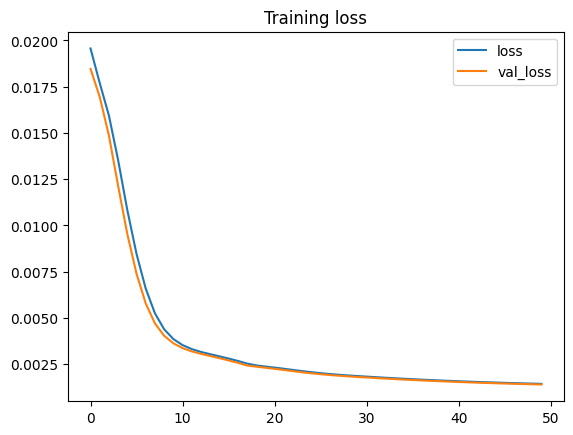

In [8]:
plt.title("Training loss")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()


In [9]:
train_reconstructed = autoencoder(X_train) 
test_reconstructed = autoencoder(X_test) 

train_errors = np.mean((X_train - train_reconstructed) ** 2, axis=1)
test_errors = np.mean((X_test - test_reconstructed) ** 2, axis=1)

threshold = np.quantile(train_errors, 1-contamination_rate)
print(threshold)

anomalies_train = (train_errors > threshold).astype(int)
anomalies_test = (test_errors > threshold).astype(int)

print(f"Balanced accuracy train: {balanced_accuracy_score(y_train, anomalies_train)}")
print(f"Balanced accuracy test: {balanced_accuracy_score(y_test, anomalies_test)}")

0.006574539751778387
Balanced accuracy train: 0.9354271885521885
Balanced accuracy test: 0.9298281122077848
